# **IMPORTING LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency,chi2
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# **FUNCTIONS**

In [3]:
# Function to categorize player positions
def categorize_position(positions):
    position = positions.split(', ') [0] # Split positions if multiple
    if 'GK' in position:
        return 'GK'
    elif any(pos in position for pos in ['LCM', 'RCM', 'CDM', 'LDM', 'RDM', 'CM', 'LM','RM', 'LAM', 'RAM','MID']):
      return 'MID'
    elif any(pos in position for pos in ['LCB','RCB', 'LB', 'RB', 'LWB', 'RWB', 'CB','DEF']):
        return 'DEF'
    elif any(pos in position for pos in ['CAM','LS', 'ST','RS', 'LW', 'RW','CF', 'RF', 'LF', 'FW']):
        return 'FW'
    else:
        return 'Other'


In [4]:
# Function to categorize body types
def categorize_body_type(body_type):
  if 'Lean' in body_type:
    return 'Lean'
  elif 'Stocky' in body_type:
    return 'Stocky'
  elif 'Normal' in body_type:
    return 'Normal'
  elif 'Messi' in body_type:
    return 'Messi'
  elif 'C. Ronaldo' in body_type:
    return 'C. Ronaldo'
  elif 'Akinfenwa' in body_type:
    return 'Akinfenwa'
  elif 'Shaqiri' in body_type:
    return 'Shaqiri'
  elif 'Neymar' in body_type:
    return 'Neymar'
  elif 'Mohamed Salah' in body_type:
    return 'Mohamed Salah'
  elif 'Courtois' in body_type:
    return 'Courtois'
  else:
    return 'Other'

In [5]:
def chi2_test(df1, df2):
  alpha = 0.05
  cont_table = pd.crosstab(index=df1,columns=df2)
  #cont_table.head()
  # chi2 value, p value, degree of freedom , expected_table
  chi2_value, p, dof, expected_table = chi2_contingency(cont_table)

  print(f'chi2 value: {chi2_value}')
  print(f'p value: {p}')
  print(f'degree of freedom: {dof}')
  if p <= alpha:
    print(f'Reject null hypothesis. There exist some relation between features')
  else:
    print(f'Accept null hypothesis. Two features are not related')

In [6]:
#function to display null value percentage
def get_miss_percent(null_to_handle, df):
  percent_missing = []
  col_name = []
  for col in null_to_handle:
    percent_missing.append(df[col].isna().sum() * 100 / len(df[col]))
    col_name.append(col)
  missing_value_df = pd.DataFrame({'column_name': col_name,
                                 'percent_missing': percent_missing})
  return missing_value_df

In [7]:
def compare_models(models):
  # Assign weights to R2 and MSE
  weight_r2 = 0.7
  weight_mse = 0.3

  # Calculate rankings for R2 and MSE
  rank_r2 = sorted(models, key=lambda x: x['r2'], reverse=True)
  rank_mse = sorted(models, key=lambda x: x['mse'])

  # Calculate weighted rankings
  weighted_rank = []
  for model in models:
    weighted_rank.append({
        'model_name': model['Name'],
        'overall_rank': (rank_r2.index(model) * weight_r2) + (rank_mse.index(model) * weight_mse)
    })
  print(pd.DataFrame(weighted_rank))
  # Choose the model with the lowest overall ranking as the best model
  best_model = min(weighted_rank, key=lambda x: x['overall_rank'])

  print("\nBest Model:", best_model['model_name'])
  model_df = pd.DataFrame(models)
  model_df

# **DATASET UNDERSTANDING AND NULL HANDLING**

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [9]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [10]:
df = pd.read_csv("/content/drive/My Drive/Datasets/players_21.csv")

In [11]:
df.head(30)

sofifa_id                                         player_url           short_name  \
0      158023  https://sofifa.com/player/158023/lionel-messi/...             L. Messi   
1       20801  https://sofifa.com/player/20801/c-ronaldo-dos-...    Cristiano Ronaldo   
2      200389  https://sofifa.com/player/200389/jan-oblak/210002             J. Oblak   
3      188545  https://sofifa.com/player/188545/robert-lewand...       R. Lewandowski   
4      190871  https://sofifa.com/player/190871/neymar-da-sil...            Neymar Jr   
5      192985  https://sofifa.com/player/192985/kevin-de-bruy...         K. De Bruyne   
6      231747  https://sofifa.com/player/231747/kylian-mbappe...            K. Mbappé   
7      192448  https://sofifa.com/player/192448/marc-andre-te...        M. ter Stegen   
8      203376  https://sofifa.com/player/203376/virgil-van-di...          V. van Dijk   
9      212831  https://sofifa.com/player/212831/alisson-ramse...              Alisson   
10     208722  https://sofifa.com/player/208722/sadio-mane/21...              S. Mané   
11     209331  https://sofifa.com/player/209331/mohamed-salah...             M. Salah   
12     192119  https://sofifa.com/player/192119/thibaut-court...          T. Courtois   
13     153079  https://sofifa.com/player/153079/sergio-aguero...            S. Agüero   
14     155862  https://sofifa.com/player/155862/sergio-ramos-...         Sergio Ramos   
15     165153  https://sofifa.com/player/165153/karim-benzema...           K. Benzema   
16     167495  https://sofifa.com/player/167495/manuel-neuer/...             M. Neuer   
17     200145  https://sofifa.com/player/200145/carlos-henriq...             Casemiro   
18     210257  https://sofifa.com/player/210257/ederson-santa...              Ederson   
19     202652  https://sofifa.com/player/202652/raheem-sterli...          R. Sterling   
20     212622  https://sofifa.com/player/212622/joshua-kimmic...           J. Kimmich   
21     202126  https://sofifa.com/player/202126/harry-kane/21...              H. Kane   
22     211110  https://sofifa.com/player/211110/paulo-dybala/...            P. Dybala   
23     162835  https://sofifa.com/player/162835/samir-handano...        S. Handanovič   
24     182521  https://sofifa.com/player/182521/toni-kroos/21...             T. Kroos   
25     183277  https://sofifa.com/player/183277/eden-hazard/2...            E. Hazard   
26     201024  https://sofifa.com/player/201024/kalidou-kouli...         K. Koulibaly   
27     215914  https://sofifa.com/player/215914/ngolo-kante/2...             N. Kanté   
28     233049  https://sofifa.com/player/233049/jadon-sancho/...            J. Sancho   
29     231281  https://sofifa.com/player/231281/trent-alexand...  T. Alexander-Arnold   

                              long_name  age         dob  height_cm  weight_kg  nationality  \
0        Lionel Andrés Messi Cuccittini   33  1987-06-24        170         72    Argentina   
1   Cristiano Ronaldo dos Santos Aveiro   35  1985-02-05        187         83     Portugal   
2                             Jan Oblak   27  1993-01-07        188         87     Slovenia   
3                    Robert Lewandowski   31  1988-08-21        184         80       Poland   
4         Neymar da Silva Santos Júnior   28  1992-02-05        175         68       Brazil   
5                       Kevin De Bruyne   29  1991-06-28        181         70      Belgium   
6                  Kylian Mbappé Lottin   21  1998-12-20        178         73       France   
7                 Marc-André ter Stegen   28  1992-04-30        187         85      Germany   
8                       Virgil van Dijk   28  1991-07-08        193         92  Netherlands   
9                 Alisson Ramsés Becker   27  1992-10-02        191         91       Brazil   
10                           Sadio Mané   28  1992-04-10        175         69      Senegal   
11                  Mohamed Salah Ghaly   28  1992-06-15        175         71        Egypt   
12       

In [12]:
null_to_handle=[]
for col in df.columns:
  if df[col].isna().sum() > 0:
    null_to_handle.append(col)
print(f"columns to handle null values: {null_to_handle}")

columns to handle null values: ['club_name', 'league_name', 'league_rank', 'release_clause_eur', 'player_tags', 'team_position', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_position', 'nation_jersey_number', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'player_traits', 'defending_marking']


In [13]:
get_miss_percent(null_to_handle, df)

column_name  percent_missing
0              club_name         1.187711
1            league_name         1.187711
2            league_rank         1.187711
3     release_clause_eur         5.252323
4            player_tags        92.567568
5          team_position         1.187711
6     team_jersey_number         1.187711
7            loaned_from        95.998733
8                 joined         5.188978
9   contract_valid_until         1.187711
10       nation_position        94.050887
11  nation_jersey_number        94.050887
12                  pace        10.995566
13              shooting        10.995566
14               passing        10.995566
15             dribbling        10.995566
16             defending        10.995566
17                physic        10.995566
18             gk_diving        89.004434
19           gk_handling        89.004434
20            gk_kicking        89.004434
21           gk_reflexes        89.004434
22              gk_speed        89.004434
23        gk_positioning        89.004434
24         player_traits        56.107475
25     defending_marking       100.000000

In [14]:
#column dropped as so many null values 'player_tags','defending_marking'
df.drop(['player_tags','defending_marking'],axis=1,inplace=True)
null_to_handle.remove('player_tags')
null_to_handle.remove('defending_marking')

In [15]:
#columns dropped as they are id values 'club_name', 'league_name','nation_position', 'nation_jersey_number','team_jersey_number'
df.drop(['club_name','nation_position','team_jersey_number', 'nation_jersey_number'],axis=1,inplace=True)
null_to_handle.remove('club_name')
null_to_handle.remove('nation_position')
null_to_handle.remove('nation_jersey_number')
null_to_handle.remove('team_jersey_number')

In [16]:
#columns dropped as they derived from target column 'release_clause_eur'
df.drop(['release_clause_eur'],axis=1,inplace=True)
null_to_handle.remove('release_clause_eur')

In [17]:
#column to handle not affecting overall 'loaned_from', 'joined', 'contract_valid_until'
df.drop(['loaned_from','joined', 'contract_valid_until'],axis=1,inplace=True)
null_to_handle.remove('joined')
null_to_handle.remove('contract_valid_until')
null_to_handle.remove('loaned_from')

We found that
* 'pace','shooting','passing','dribbling','defending','physic' have null values for player_position = 'GK'
* 'gk_diving','gk_handling','gk_kicking','gk_reflexes','gk_speed','gk_positioning' have null values for all other player_position

**Conclusion: We need to handle and select features based on player_position**

In [18]:
#filling those columns with 0
for col in ['pace','shooting','passing','dribbling','defending','physic','gk_diving','gk_handling','gk_kicking','gk_reflexes','gk_speed','gk_positioning']:
  df[col].fillna(0,inplace=True)
  null_to_handle.remove(col)

In [19]:
null_to_handle

['league_name', 'league_rank', 'team_position', 'player_traits']

In [20]:
print("Rows with null laegue_rank: ", df.loc[df['league_rank'].isnull(),['league_name','team_position']].index.size)
df.loc[df['league_rank'].isnull(),['league_name','team_position']]

Rows with null laegue_rank:  225


league_name team_position
359           NaN           NaN
363           NaN           NaN
494           NaN           NaN
495           NaN           NaN
496           NaN           NaN
497           NaN           NaN
498           NaN           NaN
499           NaN           NaN
500           NaN           NaN
501           NaN           NaN
502           NaN           NaN
528           NaN           NaN
583           NaN           NaN
626           NaN           NaN
679           NaN           NaN
680           NaN           NaN
681           NaN           NaN
682           NaN           NaN
895           NaN           NaN
896           NaN           NaN
897           NaN           NaN
999           NaN           NaN
1027          NaN           NaN
1037          NaN           NaN
1172          NaN           NaN
1173          NaN           NaN
1174          NaN           NaN
1175          NaN           NaN
1176          NaN           NaN
1338          NaN           NaN
1367          NaN           NaN
1424          NaN           NaN
1432          NaN           NaN
1453          NaN           NaN
1479          NaN           NaN
1495          NaN           NaN
1496          NaN           NaN
1497          NaN           NaN
1588          NaN           NaN
1842          NaN           NaN
1947          NaN           NaN
2034          NaN           NaN
2035          NaN           NaN
2036          NaN           NaN
2038          NaN           NaN
2039          NaN           NaN
2180          NaN           NaN
2433          NaN           NaN
2442          NaN           NaN
2487          NaN           NaN
2564          NaN           NaN
2589          NaN           NaN
2605          NaN           NaN
2613          NaN           NaN
2629          NaN           NaN
2697          NaN           NaN
2706          NaN           NaN
2781          NaN           NaN
2844          NaN           NaN
2885          NaN           NaN
2955          NaN           NaN
2992          NaN           NaN
3001          NaN           NaN
3057          NaN           NaN
3058          NaN           NaN
3359          NaN           NaN
3403          NaN           NaN
3499          NaN           NaN
3539          NaN           NaN
3562          NaN           NaN
3623          NaN           NaN
3664          NaN           NaN
3677          NaN           NaN
3708          NaN           NaN
3734          NaN           NaN
3801          NaN           NaN
3802          NaN           NaN
3803          NaN           NaN
3804          NaN           NaN
3881          NaN           NaN
3989          NaN           NaN
4086          NaN           NaN
4088          NaN           NaN
4344          NaN           NaN
4358          NaN           NaN
4387          NaN           NaN
4401          NaN           NaN
4410          NaN           NaN
4501          NaN           NaN
4715          NaN           NaN
4747          NaN           NaN
4781          NaN           NaN
4791          NaN           NaN
4805          NaN           NaN
4855          NaN           NaN
4881          NaN           NaN
4970          NaN           NaN
5004          NaN           NaN
5128          NaN           NaN
5165          NaN           NaN
5208          NaN           NaN
5209          NaN           NaN
5234          NaN           NaN
5243          NaN           NaN
5356          NaN           NaN
5391          NaN           NaN
5392          NaN           NaN
5409          NaN           NaN
5471          NaN           NaN
5620          NaN           NaN
5666          NaN           NaN
5691          NaN           NaN
5792          NaN           NaN
5794          NaN           NaN
5817          NaN           NaN
5838          NaN           NaN
5845          NaN           NaN
5909          NaN           NaN
5920          NaN           NaN
5951          NaN           NaN
6073          NaN           NaN
6127          NaN           NaN
6153          NaN           NaN
6208          NaN           NaN
6210  

**Conclusion**: League_rank and team_position are given null only where there is no league_name. We can drop those rows (225 rows) from prediction dataset (to confirm)

In [21]:
df.dropna(subset=['league_rank'], inplace = True)

In [22]:
df.isna().sum()[df.isna().sum() != 0]

player_traits    10533
dtype: int64

data split to 2 sets: 1. player_traits = null 2. not null

In [23]:
null_df = df[df['player_traits'].isnull()]
non_null_df = df[df['player_traits'].notnull()]

To start with data preprocessing, deleting insignificant features from dataset

In [24]:
final_withoutplayertraits = df.drop(['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob', 'height_cm',
       'weight_kg', 'nationality', 'league_name','potential',
       'value_eur', 'wage_eur','real_face','ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram',
       'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb',
       'rb', 'player_traits'], axis = 1)

In [25]:
print(final_withoutplayertraits.shape)

(18719, 55)


# **FEATURE REDUCTION AND OPTIMIZAION**

Team_position is a subset of player_positions.
* player_positions- potential versatility of players
* team_position- actual role assigned in a team setup/match

Hence choosing player_positions over team_position

**Conclusion**: We can drop team_position and group player_positions to sub categories.

In [26]:
final_withoutplayertraits["player_positions"].value_counts().head(30)

player_positions
CB         2408
GK         2053
ST         1875
CDM, CM     811
CM          805
LB          764
CM, CDM     688
RB          650
CDM         343
RM          268
CAM         264
LM          259
CB, RB      234
CAM, CM     226
LM, RM      221
CM, CAM     209
CB, LB      208
CB, CDM     204
RM, LM      198
LB, LM      174
RB, LB      133
RB, CB      122
RB, RM      120
RW          119
LW          112
LB, LWB     110
LB, CB      107
LW, RW       97
CDM, CB      97
RB, RWB      96
Name: count, dtype: int64

In [27]:
# Apply categorization function to 'Position' column
final_withoutplayertraits['grouped_position'] = final_withoutplayertraits['player_positions'].apply(categorize_position)

print(final_withoutplayertraits[['player_positions','grouped_position']].head(30))

#to ask: LW, CAM

   player_positions grouped_position
0        RW, ST, CF               FW
1            ST, LW               FW
2                GK               GK
3                ST               FW
4           LW, CAM               FW
5           CAM, CM               FW
6        ST, LW, RW               FW
7                GK               GK
8                CB              DEF
9                GK               GK
10               LW               FW
11               RW               FW
12               GK               GK
13               ST               FW
14               CB              DEF
15           CF, ST               FW
16               GK               GK
17              CDM              MID
18               GK               GK
19           LW, RW               FW
20          CDM, RB              MID
21               ST               FW
22          CF, CAM               FW
23               GK               GK
24               CM              MID
25           LW, ST               FW
2

In [28]:
final_withoutplayertraits['grouped_position'].value_counts()

grouped_position
DEF    6131
MID    5821
FW     4713
GK     2054
Name: count, dtype: int64

In [29]:
final_withoutplayertraits.drop(['team_position'], axis = 1, inplace = True)

In [30]:
#checking values of body_type
df['body_type'].value_counts()

body_type
Normal                  11116
Lean                     6423
Stocky                   1065
PLAYER_BODY_TYPE_286        1
PLAYER_BODY_TYPE_318        1
PLAYER_BODY_TYPE_269        1
PLAYER_BODY_TYPE_326        1
PLAYER_BODY_TYPE_251        1
PLAYER_BODY_TYPE_367        1
PLAYER_BODY_TYPE_331        1
PLAYER_BODY_TYPE_350        1
PLAYER_BODY_TYPE_309        1
PLAYER_BODY_TYPE_261        1
PLAYER_BODY_TYPE_258        1
PLAYER_BODY_TYPE_339        1
PLAYER_BODY_TYPE_278        1
Messi                       1
PLAYER_BODY_TYPE_376        1
PLAYER_BODY_TYPE_285        1
PLAYER_BODY_TYPE_304        1
PLAYER_BODY_TYPE_274        1
PLAYER_BODY_TYPE_328        1
PLAYER_BODY_TYPE_275        1
PLAYER_BODY_TYPE_277        1
PLAYER_BODY_TYPE_324        1
PLAYER_BODY_TYPE_338        1
PLAYER_BODY_TYPE_341        1
PLAYER_BODY_TYPE_299        1
PLAYER_BODY_TYPE_317        1
PLAYER_BODY_TYPE_279        1
PLAYER_BODY_TYPE_381        1
PLAYER_BODY_TYPE_340        1
PLAYER_BODY_TYPE_335        1


In [31]:
final_withoutplayertraits['body_type'] = final_withoutplayertraits['body_type'].apply(categorize_body_type)

In [32]:
print(final_withoutplayertraits['body_type'].value_counts())

body_type
Normal           11116
Lean              6423
Stocky            1065
Other              108
Messi                1
C. Ronaldo           1
Neymar               1
Mohamed Salah        1
Courtois             1
Shaqiri              1
Akinfenwa            1
Name: count, dtype: int64


In [33]:
final_withoutplayertraits.head(10)

league_rank  overall player_positions preferred_foot  international_reputation  weak_foot  \
0          1.0       93       RW, ST, CF           Left                         5          4   
1          1.0       92           ST, LW          Right                         5          4   
2          1.0       91               GK          Right                         3          3   
3          1.0       91               ST          Right                         4          4   
4          1.0       91          LW, CAM          Right                         5          5   
5          1.0       91          CAM, CM          Right                         4          5   
6          1.0       90       ST, LW, RW          Right                         3          4   
7          1.0       90               GK          Right                         3          4   
8          1.0       90               CB          Right                         3          3   
9          1.0       90               GK          Right                         3          3   

   skill_moves      work_rate   body_type  pace  shooting  passing  dribbling  defending  physic  \
0            4     Medium/Low       Messi  85.0      92.0     91.0       95.0       38.0    65.0   
1            5       High/Low  C. Ronaldo  89.0      93.0     81.0       89.0       35.0    77.0   
2            1  Medium/Medium       Other   0.0       0.0      0.0        0.0        0.0     0.0   
3            4    High/Medium       Other  78.0      91.0     78.0       85.0       43.0    82.0   
4            5    High/Medium      Neymar  91.0      85.0     86.0       94.0       36.0    59.0   
5            4      High/High       Other  76.0      86.0     93.0       88.0       64.0    78.0   
6            5       High/Low       Other  96.0      86.0     78.0       91.0       39.0    76.0   
7            1  Medium/Medium       Other   0.0       0.0      0.0        0.0        0.0     0.0   
8            2  Medium/Medium       Other  76.0      60.0     71.0       71.0       91.0    86.0   
9            1  Medium/Medium       Other   0.0       0.0      0.0        0.0        0.0     0.0   

   gk_diving  gk_handling  gk_kicking  gk_reflexes  gk_speed  gk_positioning  attacking_crossing  \
0        0.0          0.0         0.0          0.0       0.0             0.0                  85   
1        0.0          0.0         0.0          0.0       0.0             0.0                  84   
2       87.0         92.0        78.0         90.0      52.0            90.0                  13   
3        0.0          0.0         0.0          0.0       0.0             0.0                  71   
4        0.0          0.0         0.0          0.0       0.0             0.0                  85   
5        0.0          0.0         0.0          0.0       0.0             0.0                  94   
6        0.0          0.0         0.0          0.0       0.0             0.0                  78   
7       88.0         85.0        88.0         90.0      45.0            88.0                  18   
8        0.0          0.0         0.0          0.0       0.0             0.0                  53   
9       86.0         88.0        85.0         89.0      51.0            91.0                  17   

   attacking_finishing  attacking_heading_accuracy  attacking_short_passing  attacking_volleys  \
0                   95                          70                       91                 88   
1                   95                          90                       82                 86   
2                   11                          15                       43                 13   
3                   94                          85                       84                 89   
4                   87                          62                       87                 87   
5                   82                          55                       94                 82   
6                   91                          73        

In [34]:
final_withoutplayertraits.columns

Index(['league_rank', 'overall', 'player_positions', 'preferred_foot', 'international_reputation',
       'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'pace', 'shooting', 'passing',
       'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes',
       'gk_speed', 'gk_positioning', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
       'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping',
       'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression',
       'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
       'mentality_penalties', 'mentality_composure', 'defending_standing_tackle',
       'defending_sliding_

In [35]:
#fig, ax = plt.subplots(figsize=(30, 25))
#sns.heatmap(final_withoutplayertraits.select_dtypes(include = ['int64','float64']).corr(), annot = True)
#plt.show()

# **EXPLORATORY VISUALIZATIONS**

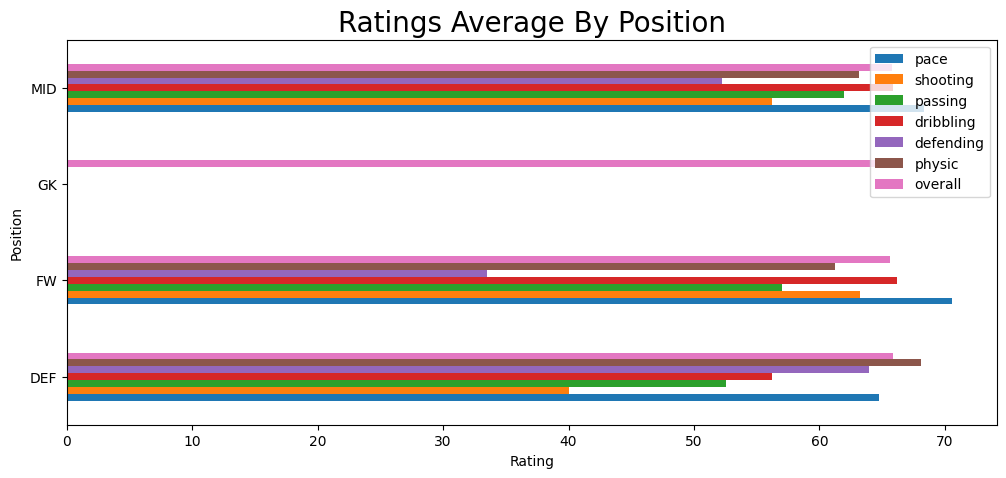

In [36]:
ratingsByPositions = final_withoutplayertraits[['pace','shooting','passing','dribbling','defending','physic','overall']].groupby([final_withoutplayertraits['grouped_position']]).mean()
ratingsByPositions = ratingsByPositions[['pace','shooting','passing','dribbling','defending','physic','overall']]
ratingsByPositions.plot(kind='barh', figsize=(12,5))

plt.title('Ratings Average By Position',fontsize=20)
plt.xlabel('Rating',fontsize=10)
plt.ylabel('Position',fontsize=10);

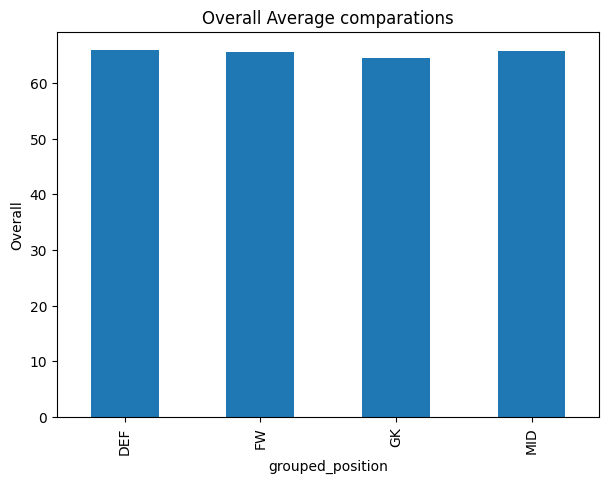

In [37]:
overall = final_withoutplayertraits[['overall']].groupby(final_withoutplayertraits['grouped_position']).mean().overall
overall.plot.bar(figsize=(7,5))
plt.ylabel('Overall')
plt.title('Overall Average comparations')

plt.show()

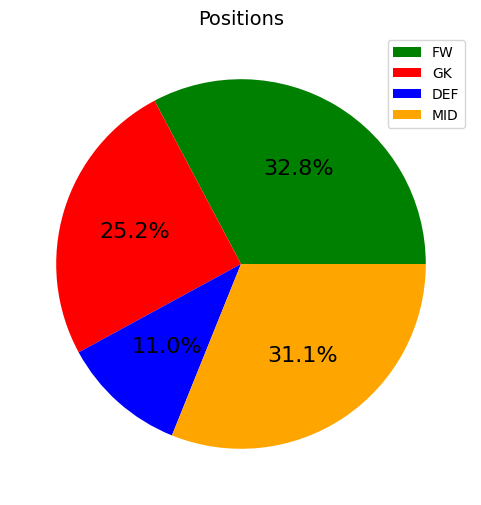

In [38]:
by_pos = final_withoutplayertraits[['grouped_position']].groupby(final_withoutplayertraits['grouped_position']).count()

by_pos.plot(kind='pie',figsize=(7,6), colors=['green','red','blue','orange','pink'], labels=None, autopct='%1.1f%%', fontsize=16, subplots = True)

plt.legend(labels=final_withoutplayertraits['grouped_position'].unique())
plt.title('Positions', fontsize=14)
plt.ylabel('')
plt.show()

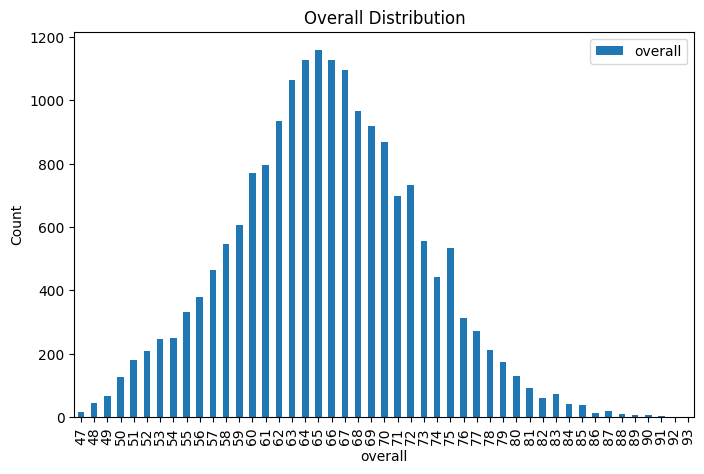

In [39]:
overall = final_withoutplayertraits[['overall']].groupby(final_withoutplayertraits['overall']).count()
overall.plot.bar(figsize=(8,5))
plt.ylabel('Count')
plt.title('Overall Distribution')
plt.rcParams["figure.figsize"] = (7,7)
plt.show()

# **PLAYER POSITION = 'GK'**
linear 0.9983

In [40]:
df_gk = final_withoutplayertraits.loc[final_withoutplayertraits['grouped_position'] == 'GK',['preferred_foot','league_rank', 'overall', 'international_reputation', 'weak_foot',
        'work_rate', 'body_type','skill_moves','gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
       'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping',
       'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression',
       'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
       'mentality_penalties', 'mentality_composure', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling',
       'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']]
df_gk.head(10)

preferred_foot  league_rank  overall  international_reputation  weak_foot      work_rate  \
2           Right          1.0       91                         3          3  Medium/Medium   
7           Right          1.0       90                         3          4  Medium/Medium   
9           Right          1.0       90                         3          3  Medium/Medium   
12           Left          1.0       89                         4          3  Medium/Medium   
16          Right          1.0       89                         5          4  Medium/Medium   
18           Left          1.0       88                         2          3  Medium/Medium   
23          Right          1.0       88                         3          3  Medium/Medium   
36           Left          1.0       87                         4          1  Medium/Medium   
40          Right          1.0       87                         3          3  Medium/Medium   
44          Right          1.0       87                         3          3  Medium/Medium   

   body_type  skill_moves  gk_diving  gk_handling  gk_kicking  gk_reflexes  gk_speed  \
2      Other            1       87.0         92.0        78.0         90.0      52.0   
7      Other            1       88.0         85.0        88.0         90.0      45.0   
9      Other            1       86.0         88.0        85.0         89.0      51.0   
12  Courtois            1       84.0         89.0        74.0         88.0      48.0   
16     Other            1       87.0         87.0        91.0         89.0      57.0   
18     Other            1       86.0         82.0        93.0         88.0      63.0   
23     Other            1       88.0         85.0        73.0         89.0      53.0   
36     Other            1       89.0         82.0        68.0         90.0      63.0   
40      Lean            1       86.0         82.0        73.0         88.0      49.0   
44    Normal            1       90.0         81.0        75.0         90.0      53.0   

    gk_positioning  attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
2             90.0                  13                   11                          15   
7             88.0                  18                   14                          11   
9             91.0                  17                   13                          19   
12            85.0                  14                   14                          13   
16            86.0                  15                   13                          25   
18            86.0                  20                   14                          14   
23            89.0                  12                   10                          10   
36            84.0                  13                   10                          10   
40            87.0                  12                   12                          16   
44            82.0                  11                   15                          11   

    attacking_short_passing  attacking_volleys  skill_dribbling  skill_curve  skill_fk_accuracy  \
2                        43                 13               12           13                 14   
7                        61                 14               21           18                 12   
9                        45                 20               27           19                 18   
12                       33                 12               13           19                 20   
16                       55                 11               30           14                 11   
18                       57                 18               23           15                 20   
23                       42                 12               18           12                 14   
36                       50                 11               10           11                 10   
40                       32                 14               11           16                 14

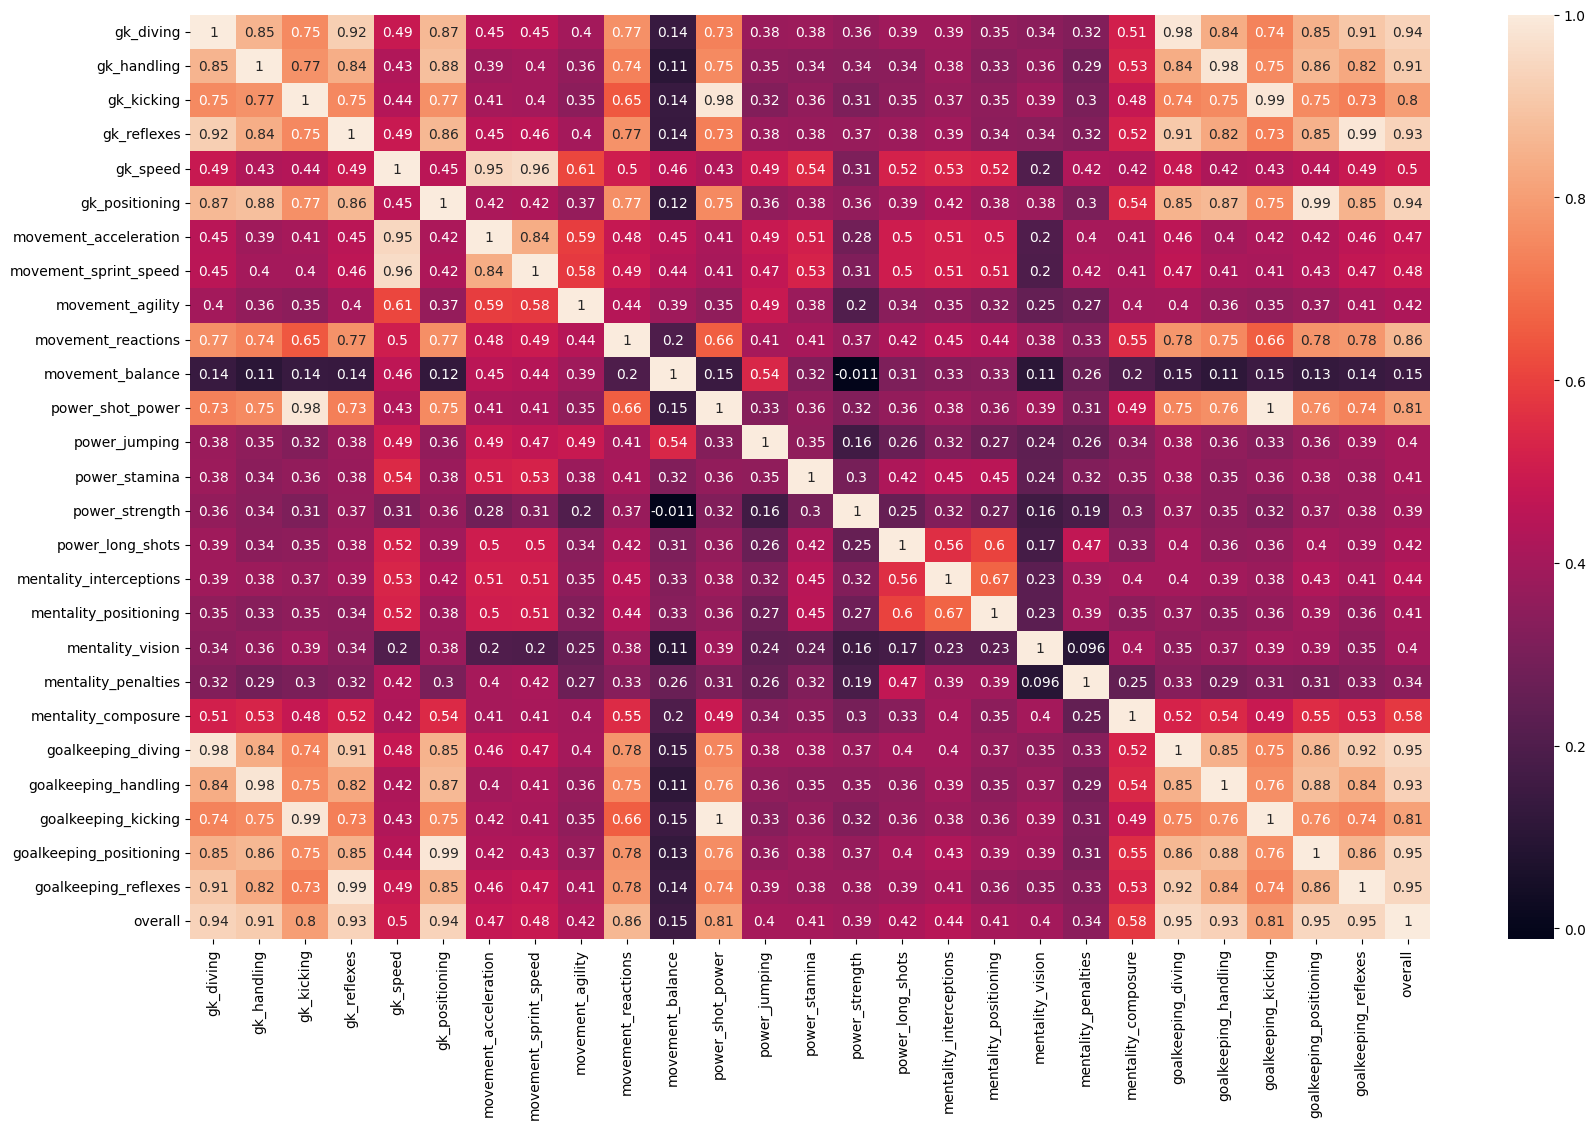

In [41]:
#cross checking correlation  for numerical data
corr_data =df_gk[['gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning','movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping',
       'power_stamina', 'power_strength', 'power_long_shots','mentality_interceptions', 'mentality_positioning', 'mentality_vision',
       'mentality_penalties', 'mentality_composure', 'goalkeeping_diving', 'goalkeeping_handling',
       'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'overall']]
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(corr_data.corr(), annot = True)
plt.show()

In [42]:
#cross checking ch2 test for discrete numerical data
for col in ['league_rank', 'international_reputation', 'weak_foot','skill_moves',
        'work_rate', 'body_type','preferred_foot']:
  print("\nCh2 on ", col)
  chi2_test(df_gk[col],df_gk['overall'])


Ch2 on  league_rank
chi2 value: 227.7175689741839
p value: 1.8876393514901749e-07
degree of freedom: 129
Reject null hypothesis. There exist some relation between features

Ch2 on  international_reputation
chi2 value: 2992.7007362147233
p value: 0.0
degree of freedom: 172
Reject null hypothesis. There exist some relation between features

Ch2 on  weak_foot
chi2 value: 212.6747891930588
p value: 0.018947912518703952
degree of freedom: 172
Reject null hypothesis. There exist some relation between features

Ch2 on  skill_moves
chi2 value: 0.0
p value: 1.0
degree of freedom: 0
Accept null hypothesis. Two features are not related

Ch2 on  work_rate
chi2 value: 0.0
p value: 1.0
degree of freedom: 0
Accept null hypothesis. Two features are not related

Ch2 on  body_type
chi2 value: 2441.3070884464464
p value: 0.0
degree of freedom: 172
Reject null hypothesis. There exist some relation between features

Ch2 on  preferred_foot
chi2 value: 54.92306823844214
p value: 0.10501912668671574
degree o

In [43]:
final_gk = df_gk[['league_rank', 'international_reputation', 'weak_foot', 'body_type', 'movement_reactions','power_shot_power',
                 'goalkeeping_diving','goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']]
final_gk_target = df_gk['overall']

In [44]:
final_gk_sum = final_gk.copy()

In [45]:
#obtaining a common feature for all gk attributes using mean
final_gk_sum['GK_attribute'] = final_gk_sum[['goalkeeping_diving','goalkeeping_handling', 'goalkeeping_kicking',
                                     'goalkeeping_positioning', 'goalkeeping_reflexes']].sum(axis = 1)

In [46]:
final_gk_sum.drop(['goalkeeping_diving','goalkeeping_handling', 'goalkeeping_kicking',
                                     'goalkeeping_positioning', 'goalkeeping_reflexes'], axis = 1, inplace = True)

In [47]:
final_gk_sum.head()

league_rank  international_reputation  weak_foot body_type  movement_reactions  \
2           1.0                         3          3     Other                  88   
7           1.0                         3          4     Other                  86   
9           1.0                         3          3     Other                  88   
12          1.0                         4          3  Courtois                  84   
16          1.0                         5          4     Other                  86   

    power_shot_power  GK_attribute  
2                 59           437  
7                 66           439  
9                 64           439  
12                56           420  
16                68           440

In [48]:
encoded_final_gk = final_gk_sum.copy()

#label encode object variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
col_toencode = encoded_final_gk.select_dtypes(['object'])
for col in col_toencode.columns:
  encoded_final_gk[col] = le.fit_transform(encoded_final_gk[col])



**Scaling and outlier handling skipped as all columns are discrete numerical.**

Normalization

In [49]:
#from sklearn.preprocessing import normalize
#x_norm = normalize(scaled_gk)
#norm_gk = pd.DataFrame(x_norm)
#norm_gk.describe()

Prediction models

In [50]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(encoded_final_gk, final_gk_target, test_size=0.2, random_state=42)

# Create a list to store information about different regression models
models = []

In [51]:
#linear regression model
lm = LinearRegression()
lm_model = lm.fit(X_train.values, y_train)
y_pred = lm_model.predict(X_test.values)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'Linear Regression', 'mse': mse, 'r2': r2})

R-squared (R2) score: 0.9983371813111835
Mean-squared error (MSE): 0.10074137034632426


In [52]:
# Create the XGBRegressor model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'XGBRegressor', 'mse': mse, 'r2': r2})

R-squared (R2) score: 0.9961105889546059
Mean-squared error (MSE): 0.23563879885906358


In [53]:
#random forest classifier
rf_cl = RandomForestClassifier(random_state = 1, n_estimators=20, max_depth = 20, criterion='entropy')
rf_cl.fit(X_train, y_train)
y_pred = rf_cl.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'Random forest', 'mse': mse, 'r2': r2})

R-squared (R2) score: 0.9813255347747729
Mean-squared error (MSE): 1.1313868613138687


In [54]:
#decision tree model
dt_cl = DecisionTreeClassifier(random_state =2)
dt_cl.fit(X_train, y_train)
y_pred = dt_cl.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'Decision tree', 'mse': mse, 'r2': r2})

R-squared (R2) score: 0.9902410859145587
Mean-squared error (MSE): 0.5912408759124088


Comparing models by weighted scores of R2 and MSE

In [55]:
compare_models(models)

          model_name  overall_rank
0  Linear Regression           0.0
1       XGBRegressor           1.0
2      Random forest           3.0
3      Decision tree           2.0

Best Model: Linear Regression


# **PLAYER POSITION = 'DEF'**
xgb 0.9729

In [56]:
df_DEF = final_withoutplayertraits.loc[final_withoutplayertraits['grouped_position'] == 'DEF',[ 'preferred_foot','league_rank', 'international_reputation',
        'weak_foot','work_rate', 'body_type','pace', 'shooting',
        'passing','dribbling', 'defending', 'physic','attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
       'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping',
       'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression',
       'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
       'mentality_penalties', 'mentality_composure', 'defending_standing_tackle',
       'defending_sliding_tackle','overall']]
df_DEF.head(5)

preferred_foot  league_rank  international_reputation  weak_foot      work_rate body_type  \
8           Right          1.0                         3          3  Medium/Medium     Other   
14          Right          1.0                         4          3    High/Medium     Other   
26          Right          1.0                         3          3    Medium/High     Other   
29          Right          1.0                         2          4    High/Medium     Other   
31           Left          1.0                         2          3  Medium/Medium     Other   

    pace  shooting  passing  dribbling  defending  physic  attacking_crossing  \
8   76.0      60.0     71.0       71.0       91.0    86.0                  53   
14  71.0      70.0     76.0       73.0       88.0    85.0                  66   
26  75.0      28.0     55.0       68.0       89.0    86.0                  30   
29  80.0      66.0     87.0       80.0       80.0    71.0                  93   
31  63.0      50.0     72.0       68.0       88.0    81.0                  58   

    attacking_finishing  attacking_heading_accuracy  attacking_short_passing  attacking_volleys  \
8                    52                          87                       79                 45   
14                   65                          92                       82                 69   
26                   22                          84                       74                 14   
29                   56                          69                       85                 62   
31                   45                          86                       82                 40   

    skill_dribbling  skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
8                70           60                 70                  86                  77   
14               65           74                 76                  83                  83   
26               69           28                 28                  63                  74   
29               77           88                 85                  89                  87   
31               63           61                 69                  80                  78   

    movement_acceleration  movement_sprint_speed  movement_agility  movement_reactions  \
8                      72                     79                61                  89   
14                     72                     70                78                  92   
26                     73                     77                52                  85   
29                     77                     83                74                  83   
31                     60                     65                59                  87   

    movement_balance  power_shot_power  power_jumping  power_stamina  power_strength  \
8                 53                81             90             75              92   
14                66                79             93             81              85   
26                41                55             82             70              94   
29                74                80             66             88              62   
31                60                68             76             72              85   

    power_long_shots  mentality_aggression  mentality_interceptions  mentality_positioning  \
8                 64                    83                       90                     47   
14                64                    90                       88                     73   
26                15                    87                       87                     35   
29                74                    74                       82                     76   
31                47                    81                       87                     54   

    mentality_vision  mentality_penalties  mentality_composure  defending_standing_tackle  \
8                 65                   62    

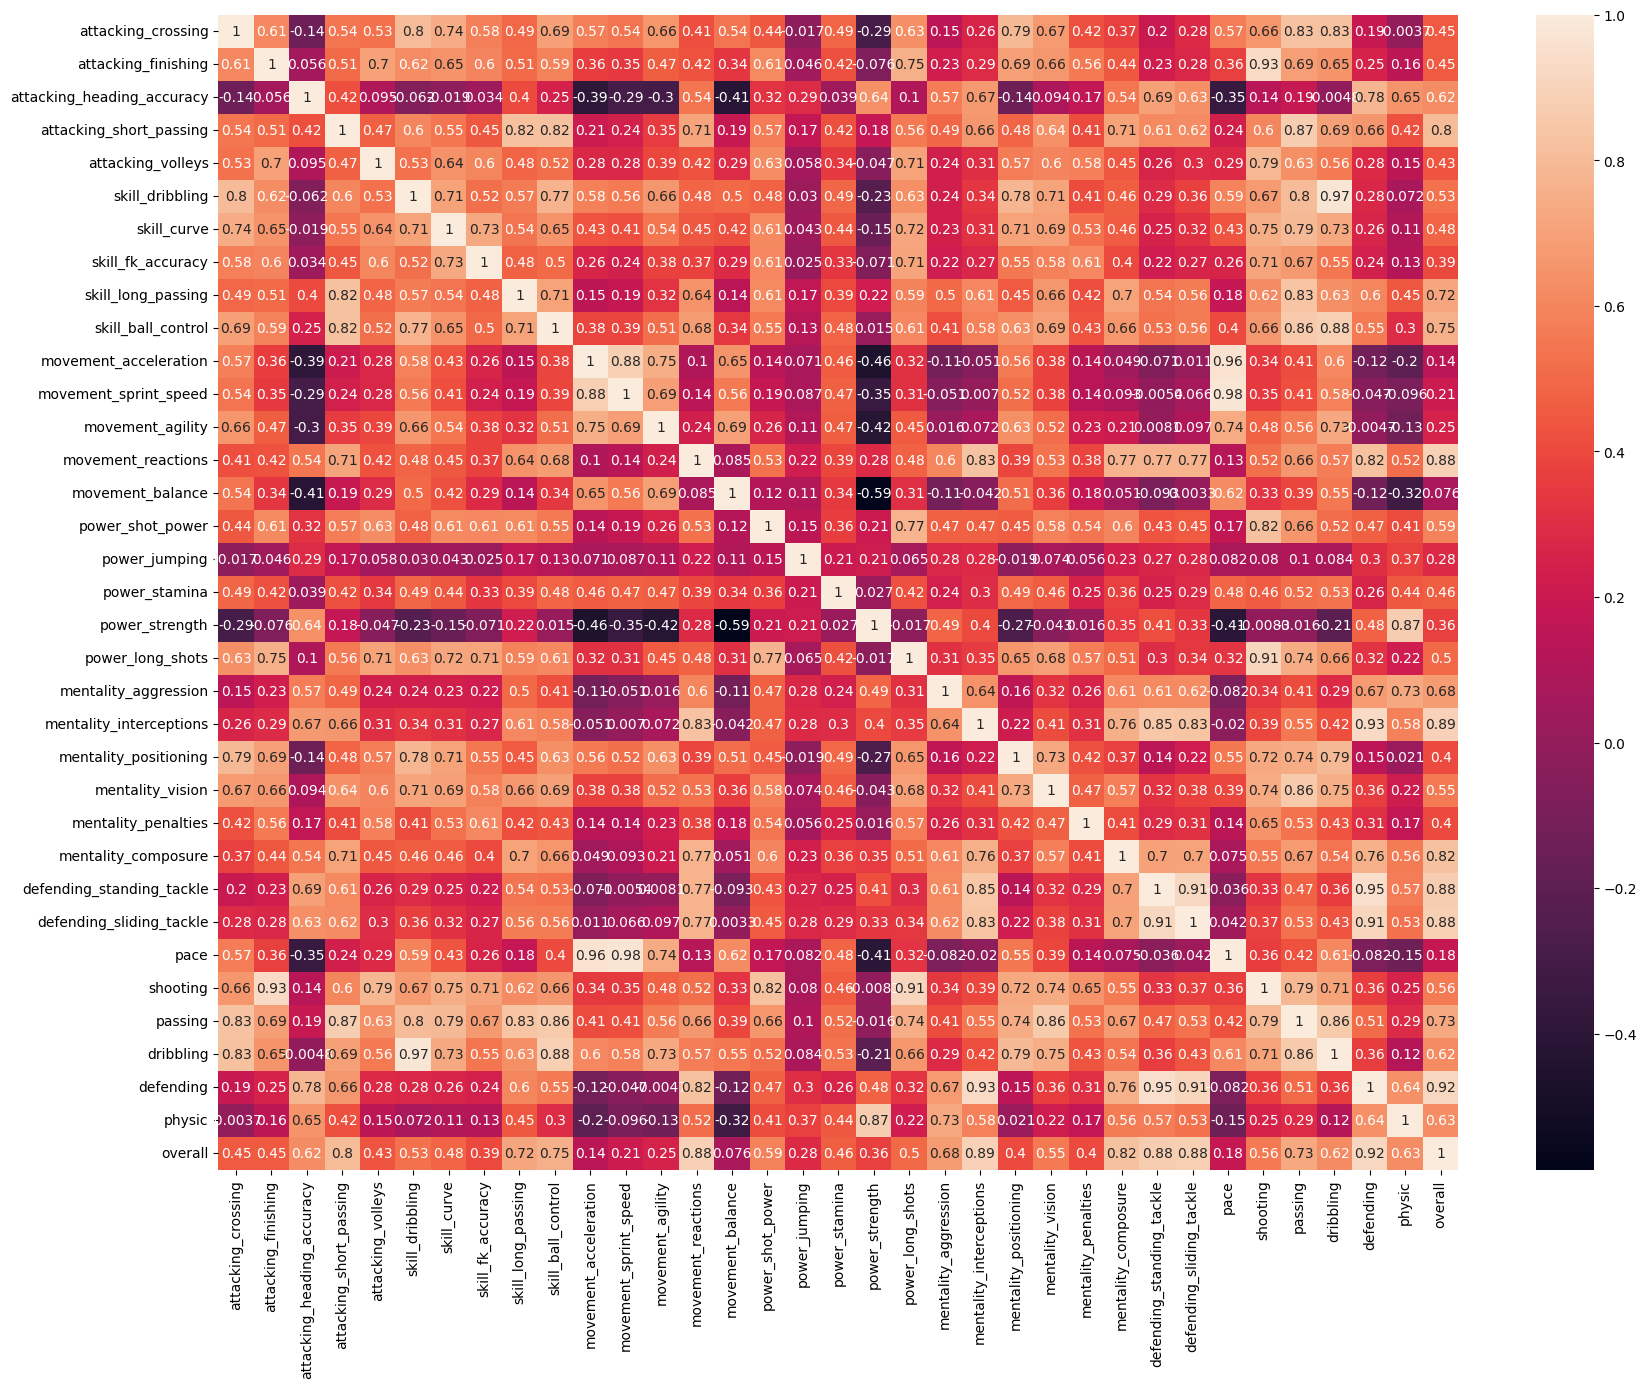

In [57]:
#cross checking correlation  for numerical data
corr_data =df_DEF[['attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
       'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping',
       'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression',
       'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
       'mentality_penalties', 'mentality_composure', 'defending_standing_tackle',
       'defending_sliding_tackle','pace', 'shooting','passing','dribbling', 'defending', 'physic', 'overall']]
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_data.corr(), annot = True)
plt.show()

In [58]:
#cross checking ch2 test for discrete numerical data
for col in ['league_rank', 'international_reputation', 'weak_foot',
        'work_rate', 'body_type','preferred_foot']:
  print("\nCh2 on ", col)
  chi2_test(df_DEF[col],df_DEF['overall'])


Ch2 on  league_rank
chi2 value: 796.1217188470325
p value: 1.249994535670483e-96
degree of freedom: 129
Reject null hypothesis. There exist some relation between features

Ch2 on  international_reputation
chi2 value: 4522.976452437985
p value: 0.0
degree of freedom: 129
Reject null hypothesis. There exist some relation between features

Ch2 on  weak_foot
chi2 value: 324.4297173886463
p value: 1.885494966177958e-11
degree of freedom: 172
Reject null hypothesis. There exist some relation between features

Ch2 on  work_rate
chi2 value: 1140.5877281910914
p value: 4.763925690709168e-86
degree of freedom: 344
Reject null hypothesis. There exist some relation between features

Ch2 on  body_type
chi2 value: 3013.6169887310766
p value: 0.0
degree of freedom: 129
Reject null hypothesis. There exist some relation between features

Ch2 on  preferred_foot
chi2 value: 40.73122838674672
p value: 0.5701677448470348
degree of freedom: 43
Accept null hypothesis. Two features are not related


In [59]:
final_DEF = df_DEF[['league_rank', 'international_reputation', 'weak_foot', 'work_rate','body_type','attacking_heading_accuracy',
                    'attacking_short_passing','skill_ball_control','movement_reactions','mentality_interceptions',
                    'mentality_composure','defending_sliding_tackle' ,'passing', 'defending','physic', 'dribbling']]
final_DEF_target = df_DEF['overall']
final_DEF.head()

league_rank  international_reputation  weak_foot      work_rate body_type  \
8           1.0                         3          3  Medium/Medium     Other   
14          1.0                         4          3    High/Medium     Other   
26          1.0                         3          3    Medium/High     Other   
29          1.0                         2          4    High/Medium     Other   
31          1.0                         2          3  Medium/Medium     Other   

    attacking_heading_accuracy  attacking_short_passing  skill_ball_control  movement_reactions  \
8                           87                       79                  77                  89   
14                          92                       82                  83                  92   
26                          84                       74                  74                  85   
29                          69                       85                  87                  83   
31                          86                       82                  78                  87   

    mentality_interceptions  mentality_composure  defending_sliding_tackle  passing  defending  \
8                        90                   90                        86     71.0       91.0   
14                       88                   88                        90     76.0       88.0   
26                       87                   82                        87     55.0       89.0   
29                       82                   81                        79     87.0       80.0   
31                       87                   85                        88     72.0       88.0   

    physic  dribbling  
8     86.0       71.0  
14    85.0       73.0  
26    86.0       68.0  
29    71.0       80.0  
31    81.0       68.0

In [60]:
final_DEF.shape

(6131, 16)

In [61]:
encoded_final_DEF = final_DEF.copy()

#label encode object variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
col_toencode = encoded_final_DEF.select_dtypes(['object'])
for col in col_toencode.columns:
  encoded_final_DEF[col] = le.fit_transform(encoded_final_DEF[col])

In [62]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(encoded_final_DEF, final_DEF_target, test_size=0.2, random_state=42)

# Create a list to store information about different regression models
models = []

In [63]:
#linear regression model
lm = LinearRegression()
lm_model = lm.fit(X_train.values, y_train)
y_pred = lm_model.predict(X_test.values)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'Linear Regression', 'mse': mse, 'r2': r2})


R-squared (R2) score: 0.9651348737708497
Mean-squared error (MSE): 1.583494527550256


In [64]:
# Create the XGBRegressor model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=20)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'XGBRegressor', 'mse': mse, 'r2': r2})

R-squared (R2) score: 0.9729861099993654
Mean-squared error (MSE): 1.2269092818624214


In [65]:
#lasso regression
lasso_model = Lasso(alpha=0.05)  # Adjust alpha (regularization parameter) as needed

# Train the model
lasso_model.fit(X_train, y_train)

# Predict the target variable for the new data
y_pred = lasso_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'Lasso Regression', 'mse': mse, 'r2': r2})

R-squared (R2) score: 0.9651817374061435
Mean-squared error (MSE): 1.5813660881021654


In [66]:
#random forest classifier
rf_cl = RandomForestClassifier(random_state = 1, n_estimators=20, max_depth = 20, criterion='entropy')
rf_cl.fit(X_train, y_train)
y_pred = rf_cl.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'Random forest', 'mse': mse, 'r2': r2})

R-squared (R2) score: 0.9478175441248429
Mean-squared error (MSE): 2.3700081499592502


In [67]:
#decision tree model
dt_cl = DecisionTreeClassifier(random_state =2)
dt_cl.fit(X_train, y_train)
y_pred = dt_cl.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'Decision tree', 'mse': mse, 'r2': r2})

R-squared (R2) score: 0.9363510416130734
Mean-squared error (MSE): 2.8907905460472696


In [68]:
compare_models(models)

          model_name  overall_rank
0  Linear Regression           2.0
1       XGBRegressor           0.0
2   Lasso Regression           1.0
3      Random forest           3.0
4      Decision tree           4.0

Best Model: XGBRegressor


In [69]:
#stratified kfold for the best model
stratified_cv = StratifiedKFold(n_splits = 50)
cv_score_str = cross_val_score(xgb_model, encoded_final_DEF,final_DEF_target, cv = stratified_cv)
print('Mean score: ',cv_score_str.mean())
print('Std deviation: ',cv_score_str.std())

Mean score:  0.9707032449013524
Std deviation:  0.006978161151717187


# **PLAYER POSITION = 'MID'**
xgb 0.9259

In [75]:
df_MID = final_withoutplayertraits.loc[final_withoutplayertraits['grouped_position'] == 'MID',[ 'preferred_foot','league_rank', 'international_reputation',
       'weak_foot','work_rate', 'body_type','skill_moves','pace', 'shooting',
       'passing','dribbling', 'defending', 'physic','attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
       'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping',
       'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression',
       'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
       'mentality_penalties', 'mentality_composure', 'defending_standing_tackle',
       'defending_sliding_tackle','overall']]
df_MID.head(10)

preferred_foot  league_rank  international_reputation  weak_foot      work_rate body_type  \
17          Right          1.0                         3          3      High/High     Other   
20          Right          1.0                         3          4    High/Medium      Lean   
24          Right          1.0                         4          5  Medium/Medium    Normal   
27          Right          1.0                         3          3    Medium/High     Other   
28          Right          1.0                         3          3    High/Medium    Normal   
32          Right          1.0                         3          2    Medium/High     Other   
38          Right          1.0                         4          4    High/Medium      Lean   
42          Right          1.0                         4          3  Medium/Medium      Lean   
46          Right          1.0                         3          5      High/High     Other   
49          Right          1.0                         4          4    High/Medium     Other   

    skill_moves  pace  shooting  passing  dribbling  defending  physic  attacking_crossing  \
17            2  65.0      73.0     76.0       72.0       86.0    91.0                  58   
20            3  71.0      72.0     86.0       84.0       81.0    79.0                  91   
24            3  54.0      81.0     91.0       81.0       71.0    69.0                  88   
27            2  77.0      66.0     76.0       81.0       86.0    82.0                  68   
28            5  83.0      74.0     81.0       91.0       37.0    64.0                  83   
32            3  67.0      69.0     79.0       77.0       85.0    83.0                  75   
38            4  73.0      76.0     89.0       88.0       71.0    66.0                  86   
42            3  42.0      62.0     80.0       80.0       83.0    77.0                  62   
46            4  88.0      86.0     80.0       87.0       43.0    69.0                  81   
49            5  73.0      81.0     86.0       85.0       66.0    85.0                  80   

    attacking_finishing  attacking_heading_accuracy  attacking_short_passing  attacking_volleys  \
17                   64                          80                       84                 63   
20                   66                          72                       87                 67   
24                   76                          58                       93                 82   
27                   65                          54                       85                 56   
28                   81                          38                       88                 83   
32                   63                          75                       85                 47   
38                   72                          55                       91                 76   
42                   67                          68                       89                 44   
46                   86                          68                       83                 81   
49                   75                          75                       86                 84   

    skill_dribbling  skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
17               69           63                 74                  84                  79   
20               83           85                 61                  86                  85   
24               80           86                 84                  93                  89   
27               79           49                 49                  79                  80   
28               92           81                 48                  68                  91   
32               76           71                 53                  83                  82   
38               85           85                 78                  89                  90   
42               81           66                 68          

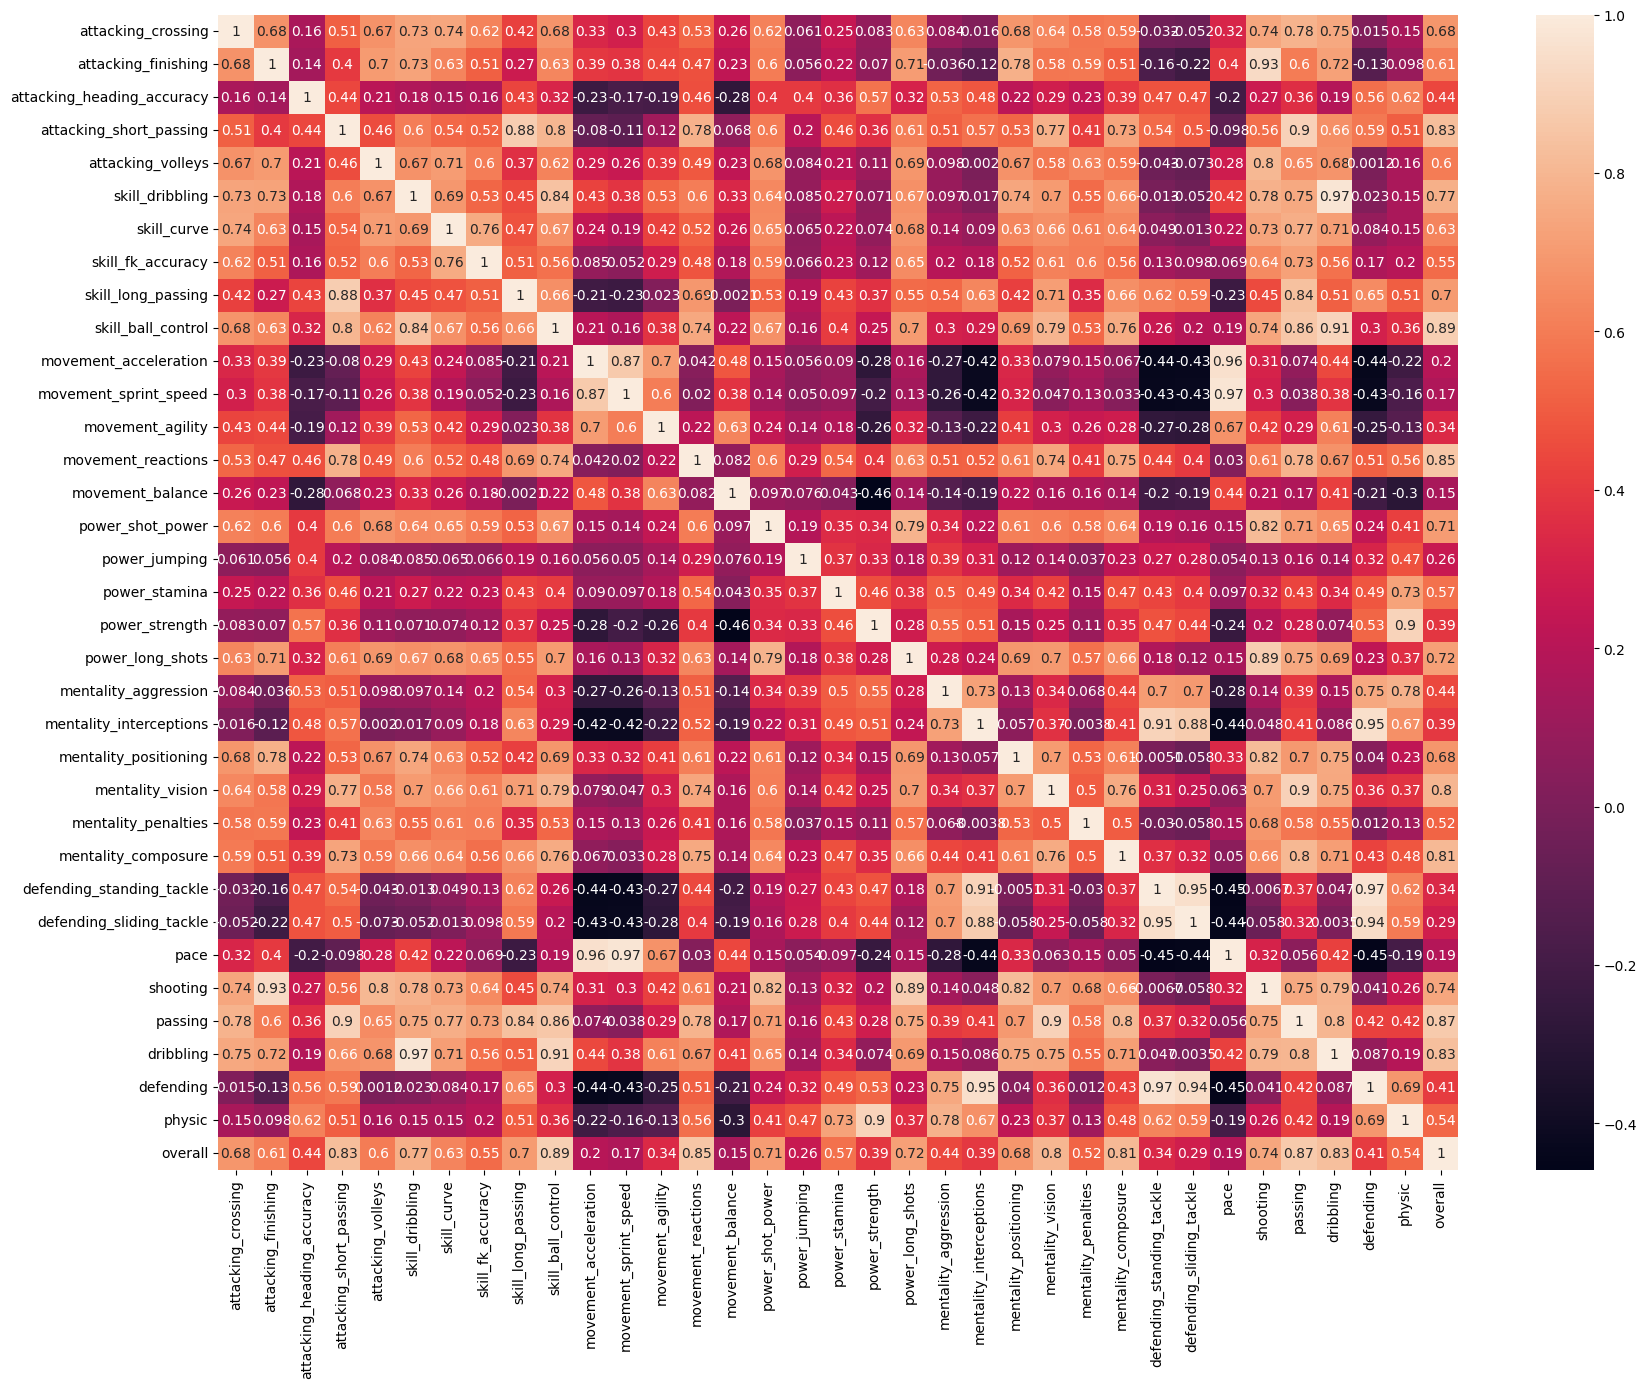

In [76]:
#cross checking correlation  for numerical data
corr_data =df_MID[['attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
       'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping',
       'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression',
       'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
       'mentality_penalties', 'mentality_composure', 'defending_standing_tackle',
       'defending_sliding_tackle','pace', 'shooting','passing','dribbling', 'defending', 'physic', 'overall']]
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_data.corr(), annot = True)
plt.show()

In [77]:
#cross checking ch2 test for discrete numerical data
for col in ['league_rank', 'international_reputation', 'weak_foot', 'skill_moves',
        'work_rate', 'body_type','preferred_foot']:
  print("\nCh2 on ", col)
  chi2_test(df_MID[col],df_MID['overall'])


Ch2 on  league_rank
chi2 value: 725.5287586445945
p value: 5.412101391171135e-85
degree of freedom: 126
Reject null hypothesis. There exist some relation between features

Ch2 on  international_reputation
chi2 value: 4082.822646590044
p value: 0.0
degree of freedom: 126
Reject null hypothesis. There exist some relation between features

Ch2 on  weak_foot
chi2 value: 578.2608987833661
p value: 1.790770741299353e-46
degree of freedom: 168
Reject null hypothesis. There exist some relation between features

Ch2 on  skill_moves
chi2 value: 2702.0221245531
p value: 0.0
degree of freedom: 126
Reject null hypothesis. There exist some relation between features

Ch2 on  work_rate
chi2 value: 1311.4041289390848
p value: 3.7361905820252724e-115
degree of freedom: 336
Reject null hypothesis. There exist some relation between features

Ch2 on  body_type
chi2 value: 2229.5526815702315
p value: 0.0
degree of freedom: 168
Reject null hypothesis. There exist some relation between features

Ch2 on  pref

In [78]:
final_MID = df_MID[['league_rank', 'international_reputation', 'weak_foot', 'skill_moves',
        'work_rate', 'body_type','preferred_foot','attacking_short_passing',
       'skill_dribbling', 'skill_long_passing','skill_ball_control','movement_reactions',
        'power_long_shots','mentality_composure','shooting','passing','dribbling']]

final_MID_target = df_MID['overall']
final_MID.head()

league_rank  international_reputation  weak_foot  skill_moves      work_rate body_type  \
17          1.0                         3          3            2      High/High     Other   
20          1.0                         3          4            3    High/Medium      Lean   
24          1.0                         4          5            3  Medium/Medium    Normal   
27          1.0                         3          3            2    Medium/High     Other   
28          1.0                         3          3            5    High/Medium    Normal   

   preferred_foot  attacking_short_passing  skill_dribbling  skill_long_passing  \
17          Right                       84               69                  84   
20          Right                       87               83                  86   
24          Right                       93               80                  93   
27          Right                       85               79                  79   
28          Right                       88               92                  68   

    skill_ball_control  movement_reactions  power_long_shots  mentality_composure  shooting  \
17                  79                  87                81                   84      73.0   
20                  85                  88                84                   85      72.0   
24                  89                  89                86                   88      81.0   
27                  80                  91                65                   85      66.0   
28                  91                  87                63                   84      74.0   

    passing  dribbling  
17     76.0       72.0  
20     86.0       84.0  
24     91.0       81.0  
27     76.0       81.0  
28     81.0       91.0

In [79]:
print(final_MID.shape)

(5821, 17)


In [80]:
encoded_final_MID = final_MID.copy()

#label encode object variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
col_toencode = encoded_final_MID.select_dtypes(['object'])
for col in col_toencode.columns:
  encoded_final_MID[col] = le.fit_transform(encoded_final_MID[col])

In [105]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(encoded_final_MID, final_MID_target, test_size=0.2, random_state=42)

# Create a list to store information about different regression models
models = []

In [106]:
#linear regression model
lm = LinearRegression()
lm_model = lm.fit(X_train.values, y_train)
y_pred = lm_model.predict(X_test.values)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'Linear Regression', 'mse': mse, 'r2': r2})

R-squared (R2) score: 0.9024782309501445
Mean-squared error (MSE): 5.213439440652724


In [107]:
#lasso regression
lasso_model = Lasso(alpha=0.1)  # Adjust alpha (regularization parameter) as needed

# Train the model
lasso_model.fit(X_train, y_train)

# Predict the target variable for the new data
y_pred = lasso_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'Lasso Regression', 'mse': mse, 'r2': r2})

R-squared (R2) score: 0.902781339736046
Mean-squared error (MSE): 5.197235475993102


In [111]:
# Create the XGBRegressor model
xgb_model = XGBRegressor(objective='reg:linear', n_estimators=50)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'XGBRegressor', 'mse': mse, 'r2': r2})

R-squared (R2) score: 0.9259357855321972
Mean-squared error (MSE): 3.959416452443623


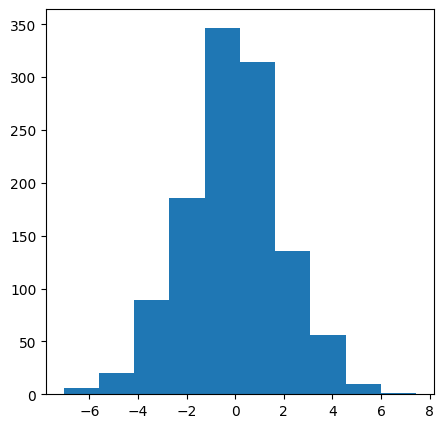

In [85]:
residuals = y_test - y_pred

fig, ax = plt.subplots(figsize=(5, 5))
plt.hist(residuals)
plt.show()

In [86]:
#random forest classifier
rf_cl = RandomForestClassifier(random_state = 1, n_estimators=20, max_depth = 20, criterion='entropy')
rf_cl.fit(X_train, y_train)
y_pred = rf_cl.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'Random forest', 'mse': mse, 'r2': r2})

R-squared (R2) score: 0.8809248784673357
Mean-squared error (MSE): 6.365665236051502


In [88]:
#decision tree model
dt_cl = DecisionTreeClassifier(random_state =2)
dt_cl.fit(X_train, y_train)
y_pred = dt_cl.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'Decision tree', 'mse': mse, 'r2': r2})

R-squared (R2) score: 0.8303789665761777
Mean-squared error (MSE): 9.067811158798284


In [89]:
compare_models(models)

          model_name  overall_rank
0  Linear Regression           2.0
1   Lasso Regression           1.0
2       XGBRegressor           0.0
3      Random forest           3.0
4      Decision tree           4.0

Best Model: XGBRegressor


In [112]:
#stratified kfold for the best model
stratified_cv = StratifiedKFold(n_splits = 50)
cv_score_str = cross_val_score(xgb_model, encoded_final_MID,final_MID_target, cv = stratified_cv)
print(cv_score_str[[0,1,2,3]])
print('Mean score: ',cv_score_str.mean())
print('Std deviation: ',cv_score_str.std())

[0.9249114  0.93160243 0.91753946 0.93398946]
Mean score:  0.9184269187097206
Std deviation:  0.013718523015579824


# **PLAYER POSITION = 'FW'**
xgb 0.9695

In [91]:
df_FW = final_withoutplayertraits.loc[final_withoutplayertraits['grouped_position'] == 'FW',[ 'preferred_foot','league_rank', 'international_reputation',
                                                                                               'weak_foot','work_rate', 'body_type','skill_moves','pace', 'shooting',
                                                                                                'passing','dribbling', 'defending', 'physic','attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
       'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping',
       'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression',
       'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
       'mentality_penalties', 'mentality_composure', 'defending_standing_tackle',
       'defending_sliding_tackle','overall']]
df_FW.head(5)

preferred_foot  league_rank  international_reputation  weak_foot    work_rate   body_type  \
0           Left          1.0                         5          4   Medium/Low       Messi   
1          Right          1.0                         5          4     High/Low  C. Ronaldo   
3          Right          1.0                         4          4  High/Medium       Other   
4          Right          1.0                         5          5  High/Medium      Neymar   
5          Right          1.0                         4          5    High/High       Other   

   skill_moves  pace  shooting  passing  dribbling  defending  physic  attacking_crossing  \
0            4  85.0      92.0     91.0       95.0       38.0    65.0                  85   
1            5  89.0      93.0     81.0       89.0       35.0    77.0                  84   
3            4  78.0      91.0     78.0       85.0       43.0    82.0                  71   
4            5  91.0      85.0     86.0       94.0       36.0    59.0                  85   
5            4  76.0      86.0     93.0       88.0       64.0    78.0                  94   

   attacking_finishing  attacking_heading_accuracy  attacking_short_passing  attacking_volleys  \
0                   95                          70                       91                 88   
1                   95                          90                       82                 86   
3                   94                          85                       84                 89   
4                   87                          62                       87                 87   
5                   82                          55                       94                 82   

   skill_dribbling  skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0               96           93                 94                  91                  96   
1               88           81                 76                  77                  92   
3               85           79                 85                  70                  88   
4               95           88                 89                  81                  95   
5               88           85                 83                  93                  92   

   movement_acceleration  movement_sprint_speed  movement_agility  movement_reactions  \
0                     91                     80                91                  94   
1                     87                     91                87                  95   
3                     77                     78                77                  93   
4                     94                     89                96                  91   
5                     77                     76                78                  91   

   movement_balance  power_shot_power  power_jumping  power_stamina  power_strength  \
0                95                86             68             72              69   
1                71                94             95             84              78   
3                82                89             84             76              86   
4                83                80             62             81              50   
5                76                91             63             89              74   

   power_long_shots  mentality_aggression  mentality_interceptions  mentality_positioning  \
0                94                    44                       40                     93   
1                93                    63                       29                     95   
3                85                    81                       49                     94   
4                84                    51                       36                     87   
5                91                    76                       66                     88   

   mentality_vision  mentality_penalties  mentality_composure  defending_standing_tackle  \
0        

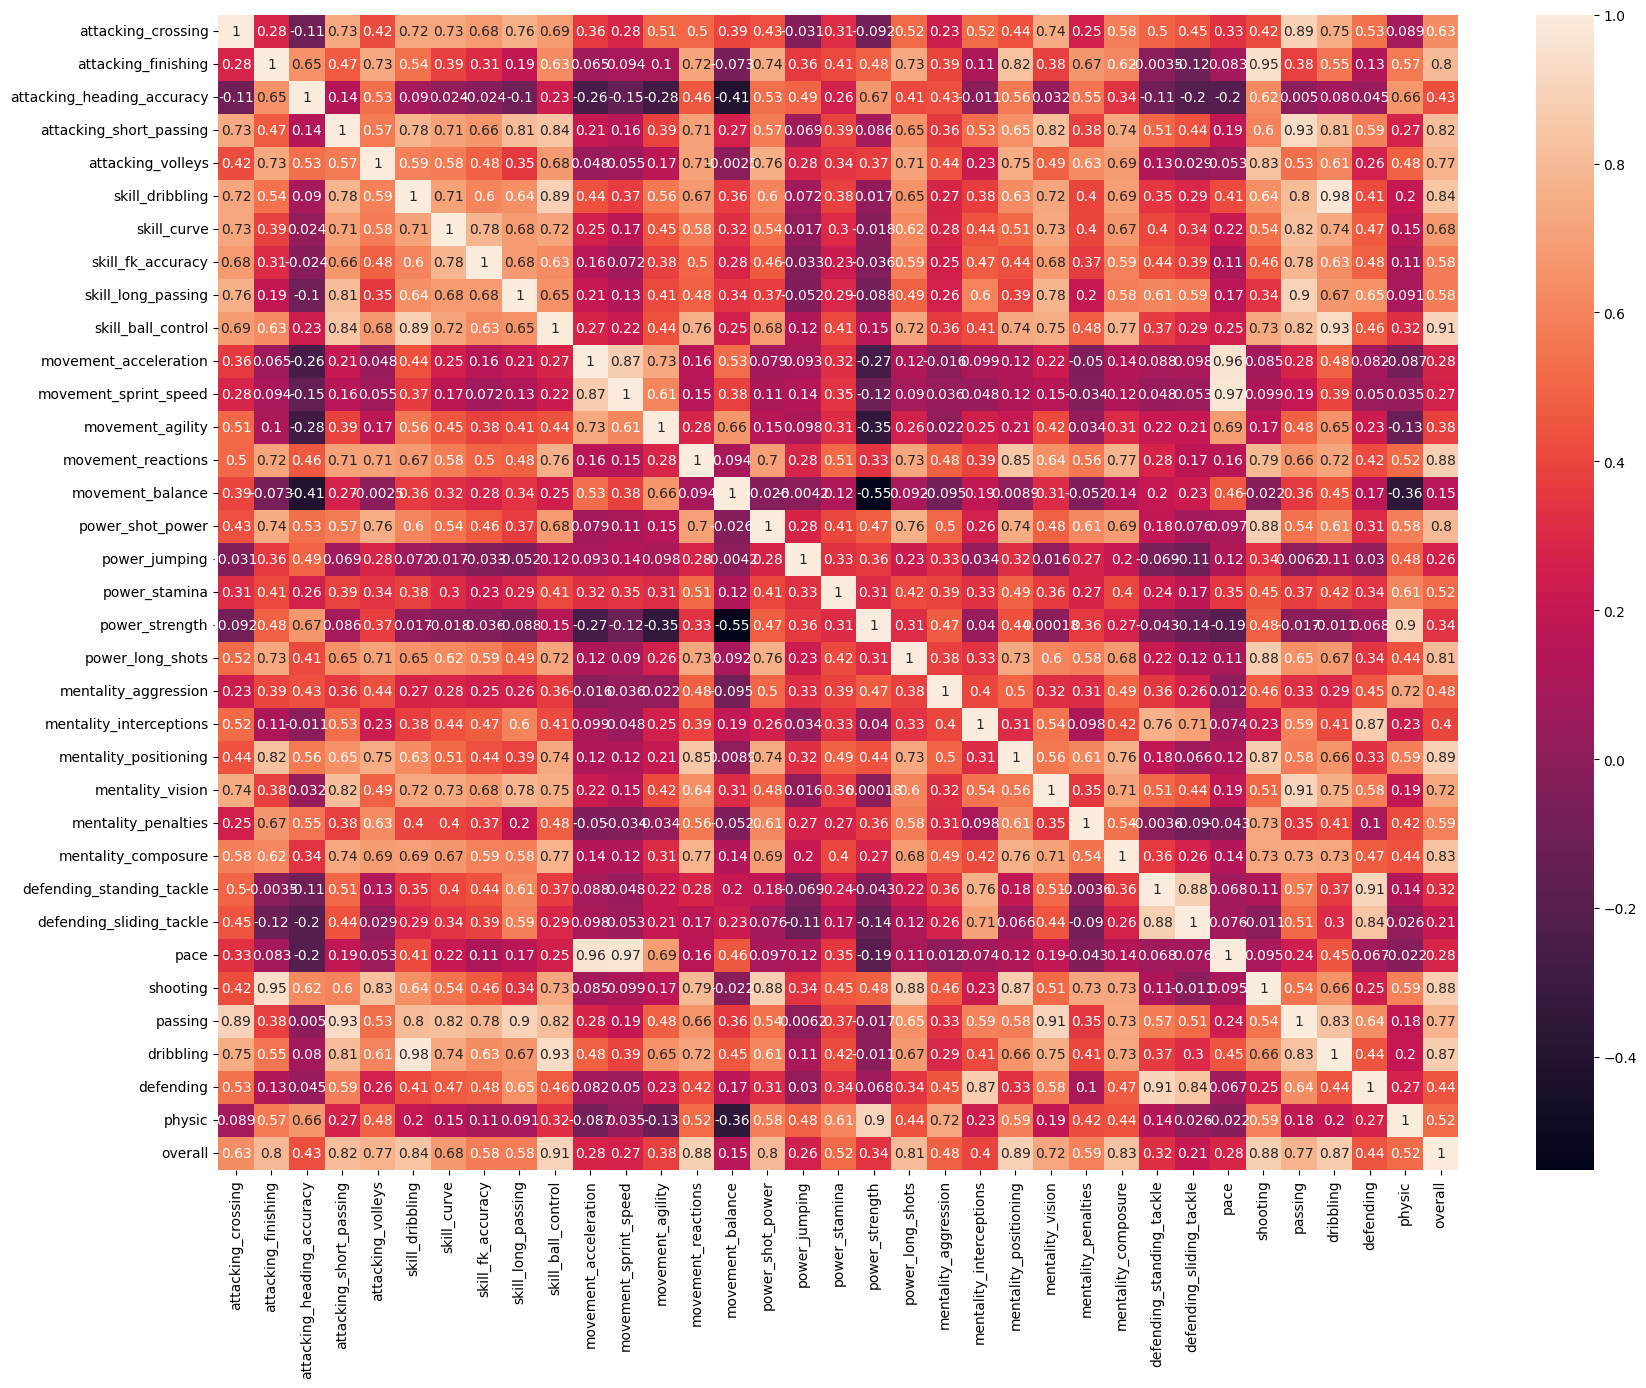

In [92]:
#cross checking correlation  for numerical data
corr_data =df_FW[['attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
       'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping',
       'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression',
       'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
       'mentality_penalties', 'mentality_composure', 'defending_standing_tackle',
       'defending_sliding_tackle','pace', 'shooting','passing','dribbling', 'defending', 'physic','overall']]
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_data.corr(), annot = True)
plt.show()

In [93]:
#cross checking ch2 test for discrete numerical data
for col in ['league_rank', 'international_reputation', 'weak_foot', 'skill_moves',
        'work_rate', 'body_type','preferred_foot']:
  print("\nCh2 on ", col)
  chi2_test(df_FW[col],df_FW['overall'])


Ch2 on  league_rank
chi2 value: 561.3509995842265
p value: 2.0298791527947113e-52
degree of freedom: 138
Reject null hypothesis. There exist some relation between features

Ch2 on  international_reputation
chi2 value: 6168.975815145024
p value: 0.0
degree of freedom: 184
Reject null hypothesis. There exist some relation between features

Ch2 on  weak_foot
chi2 value: 804.0388400235661
p value: 2.353648314984521e-78
degree of freedom: 184
Reject null hypothesis. There exist some relation between features

Ch2 on  skill_moves
chi2 value: 2839.099293224214
p value: 0.0
degree of freedom: 138
Reject null hypothesis. There exist some relation between features

Ch2 on  work_rate
chi2 value: 713.5361404003307
p value: 1.0533395308743512e-31
degree of freedom: 322
Reject null hypothesis. There exist some relation between features

Ch2 on  body_type
chi2 value: 15571.193067621658
p value: 0.0
degree of freedom: 368
Reject null hypothesis. There exist some relation between features

Ch2 on  pre

In [94]:
final_FW = df_FW[['league_rank', 'international_reputation', 'weak_foot', 'skill_moves',
        'work_rate', 'body_type','attacking_short_passing','attacking_volleys','skill_ball_control',
       'movement_reactions', 'power_shot_power','power_long_shots','mentality_positioning',
       'mentality_composure','shooting','passing','dribbling']]

final_FW_target = df_FW['overall']
final_FW.head()

league_rank  international_reputation  weak_foot  skill_moves    work_rate   body_type  \
0          1.0                         5          4            4   Medium/Low       Messi   
1          1.0                         5          4            5     High/Low  C. Ronaldo   
3          1.0                         4          4            4  High/Medium       Other   
4          1.0                         5          5            5  High/Medium      Neymar   
5          1.0                         4          5            4    High/High       Other   

   attacking_short_passing  attacking_volleys  skill_ball_control  movement_reactions  \
0                       91                 88                  96                  94   
1                       82                 86                  92                  95   
3                       84                 89                  88                  93   
4                       87                 87                  95                  91   
5                       94                 82                  92                  91   

   power_shot_power  power_long_shots  mentality_positioning  mentality_composure  shooting  \
0                86                94                     93                   96      92.0   
1                94                93                     95                   95      93.0   
3                89                85                     94                   88      91.0   
4                80                84                     87                   93      85.0   
5                91                91                     88                   91      86.0   

   passing  dribbling  
0     91.0       95.0  
1     81.0       89.0  
3     78.0       85.0  
4     86.0       94.0  
5     93.0       88.0

In [95]:
final_FW.shape

(4713, 17)

In [96]:
encoded_final_FW = final_FW.copy()

#label encode object variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
col_toencode = encoded_final_FW.select_dtypes(['object'])
for col in col_toencode.columns:
  encoded_final_FW[col] = le.fit_transform(encoded_final_FW[col])

In [113]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(encoded_final_FW, final_FW_target, test_size=0.2, random_state=42)

# Create a list to store information about different regression models
models = []

In [114]:
#linear regression model
lm = LinearRegression()
lm_model = lm.fit(X_train.values, y_train)
y_pred = lm_model.predict(X_test.values)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'Linear Regression', 'mse': mse, 'r2': r2})


R-squared (R2) score: 0.9683943898759807
Mean-squared error (MSE): 1.7478867112712932


In [115]:
# Create the XGBRegressor model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=50)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'XGBRegressor', 'mse': mse, 'r2': r2})

R-squared (R2) score: 0.969564454819094
Mean-squared error (MSE): 1.683178548468323


In [100]:
#random forest classifier
rf_cl = RandomForestClassifier(random_state = 1, n_estimators=20, max_depth = 20, criterion='entropy')
rf_cl.fit(X_train, y_train)
y_pred = rf_cl.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'Random forest', 'mse': mse, 'r2': r2})

R-squared (R2) score: 0.9460602489917074
Mean-squared error (MSE): 2.983032873806999


In [101]:
#decision tree model
dt_cl = DecisionTreeClassifier(random_state =2)
dt_cl.fit(X_train, y_train)
y_pred = dt_cl.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared (R2) score:", r2)
print("Mean-squared error (MSE):", mse)

models.append({'Name': 'Decision tree', 'mse': mse, 'r2': r2})

R-squared (R2) score: 0.9218803606086796
Mean-squared error (MSE): 4.320254506892895


In [102]:
compare_models(models)

          model_name  overall_rank
0  Linear Regression           1.0
1       XGBRegressor           0.0
2      Random forest           2.0
3      Decision tree           3.0

Best Model: XGBRegressor


In [103]:
#stratified kfold for the best model
stratified_cv = StratifiedKFold(n_splits = 10)
cv_score_str = cross_val_score(lm, encoded_final_FW,final_FW_target, cv = stratified_cv)
print('Mean score: ',cv_score_str.mean())
print('Std deviation: ',cv_score_str.std())

Mean score:  0.9658647712719333
Std deviation:  0.001590623654874416


In [104]:
print(final_MID.shape)
print(final_DEF.shape)
print(final_FW.shape)
print(final_gk.shape)

(5821, 17)
(6131, 16)
(4713, 17)
(2054, 11)
